In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyomo.environ import *

In [2]:
# rho_hat = df["Density"]
# q_hat = df["Flow"]
# print(max(q_hat))
# C_i = np.mean(sorted(q_hat)[-5:])
# print("C_i", C_i)
# K = len(rho_hat)


q_hat = (np.load("flow_10sec_400m_1hr.npy"))
print(np.max(q_hat))
rho_hat = (np.load("density_10sec_400m_1hr.npy"))
v_hat = q_hat/rho_hat
print(rho_hat.shape)
flattened_q_hat = q_hat.flatten()
print(max(flattened_q_hat))
flattened_rho_hat = rho_hat.flatten()
C_i = np.mean(np.sort(flattened_q_hat)[-5:])
print("C_i", C_i)
K = len(flattened_rho_hat)
print("K", K)

6773.200199999966
(360, 16)
6773.200199999966
C_i 6718.716719999977
K 5760


In [3]:
model = ConcreteModel()
model.k = RangeSet(0, K - 1)

# Data parameters
model.rho_hat = Param(model.k, initialize={k: flattened_rho_hat[k] for k in range(K)})
model.q_hat = Param(model.k, initialize={k: flattened_q_hat[k] for k in range(K)})
model.C = Param(initialize=C_i)  # FIXED

# Variables to optimize
model.rho_crit = Var(bounds=(1e-2, max(flattened_rho_hat)), initialize=np.median(flattened_rho_hat))
model.V_free = Var(bounds=(10, 150), initialize=60)
model.a = Var(bounds=(0.01, 10), initialize=1.0)

# Smoothed piecewise flow function
def q_pred_expr(model, k):
    rho = model.rho_hat[k]
    rho_crit = model.rho_crit
    V_free = model.V_free
    a = model.a
    Q = rho * V_free * exp(-1/a * (rho/rho_crit)**a)
    return Q

model.q_pred = Expression(model.k, rule=q_pred_expr)

# Objective function
def obj_rule(model):
    return sum((model.q_pred[k] - model.q_hat[k])**2 for k in model.k)

model.obj = Objective(rule=obj_rule, sense=minimize)
print("Initial guess:")
print(f"rho_crit = {value(model.rho_crit)}")
print(f"V_free = {value(model.V_free)}")
print(f"a = {value(model.a)}")

# Solve
solver = SolverFactory('ipopt')
solver.solve(model, tee=True)

rho_crit = value(model.rho_crit)
V_free = value(model.V_free)
a = value(model.a)

# Output
print("Optimized Parameters:")
print(f"rho_crit = {value(model.rho_crit):.3f}")
print(f"V_free = {value(model.V_free):.3f}")
print(f"a = {value(model.a):.3f}")

Initial guess:
rho_crit = 92.87499537499997
V_free = 60
a = 1.0
dyld[57816]: symbol '_CGLSetCurrentContext' missing from root that overrides /System/Library/Frameworks/OpenGL.framework/Versions/A/Libraries/libGL.dylib. Use of that symbol in /System/Library/Frameworks/OpenGL.framework/Versions/A/OpenGL is being set to 0xBAD4007.
dyld[57816]: symbol '_CGLGetCurrentContext' missing from root that overrides /System/Library/Frameworks/OpenGL.framework/Versions/A/Libraries/libGL.dylib. Use of that symbol in /System/Library/Frameworks/OpenGL.framework/Versions/A/OpenGL is being set to 0xBAD4007.
dyld[57816]: symbol '_gll_noop' missing from root that overrides /System/Library/Frameworks/OpenGL.framework/Versions/A/Libraries/libGL.dylib. Use of that symbol in /System/Library/Frameworks/OpenGL.framework/Versions/A/OpenGL is being set to 0xBAD4007.
Ipopt 3.14.17: 

******************************************************************************
This program contains Ipopt, a library for large-scale

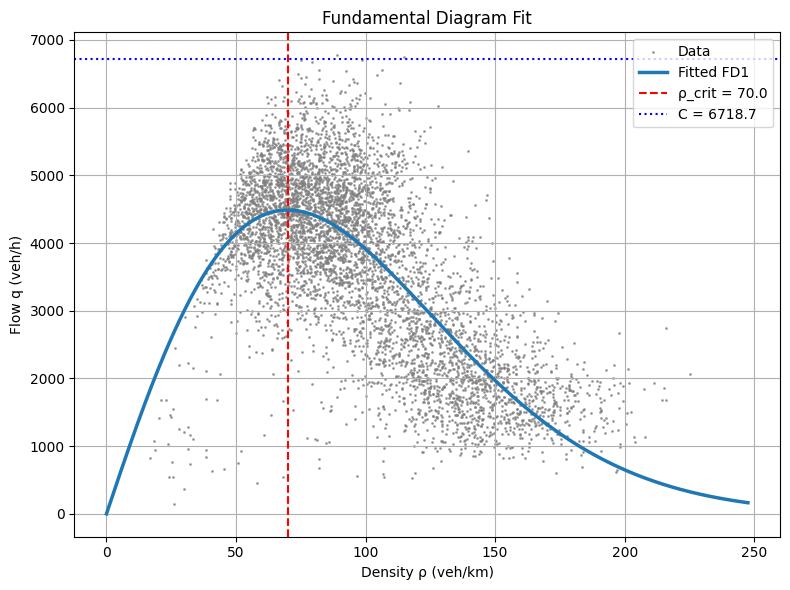

In [4]:
rho_crit = value(model.rho_crit)
V_free = value(model.V_free)
a = value(model.a)
C = np.mean(sorted(flattened_q_hat)[-5:])  # same C you used in Pyomo

# Define Q(rho) using the original piecewise FD1
def Q_fd1(rho):
    rho = np.array(rho)
    Q_free = V_free * rho * np.exp(-1/a * (rho / rho_crit)**a)
    # Q = np.where(rho <= rho_crit, Q_free, C)
    Q = Q_free
    return Q

# Generate smooth rho values for curve
rho_range = np.linspace(0, max(flattened_rho_hat)*1.1, 500)
q_fit = Q_fd1(rho_range)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(rho_hat, q_hat, color='gray', alpha=0.7, label='Data', s = 1)
plt.plot(rho_range, q_fit, linewidth=2.5, label='Fitted FD1', zorder=10)
plt.axvline(rho_crit, color='red', linestyle='--', label=f'ρ_crit = {rho_crit:.1f}')
plt.axhline(C, color='blue', linestyle=':', label=f'C = {C:.1f}')
plt.xlabel("Density ρ (veh/km)")
plt.ylabel("Flow q (veh/h)")
plt.title("Fundamental Diagram Fit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
def metanet_param_fit(v_hat, rho_hat, q_hat, T, l, initial_traffic_state, downstream_density, num_calibrated_segments, include_ramping = True, varylanes = True):
    initial_flow_or = initial_traffic_state
    
    num_timesteps, num_segments = v_hat.shape
    
    model = ConcreteModel()
    model.t = RangeSet(0, num_timesteps-1)
    model.i = RangeSet(0, num_segments-1)
    model.segment_ix = RangeSet(0, num_calibrated_segments-1)
    model.num_segments = num_segments
    model.num_calibrated_segments = num_calibrated_segments

    # Fixed params
    model.T = Param(initialize=T)
    model.l = Param(initialize=l)

    # Number of lanes (per calibrated segment)
    if varylanes:
        model.n_lanes = Var(model.segment_ix, bounds=(3, 4), initialize=3)
    else:
        model.n_lanes = Var(model.segment_ix, bounds=(4,4), initialize=4)
    # Parameters to estimate
    model.eta_high = Var(model.segment_ix, bounds=(1.0,90.0), initialize=30.0)
    model.tau = Var(model.segment_ix, bounds=(1.0/3600, 60.0/3600), initialize=18/3600)
    model.K = Var(model.segment_ix, bounds=(1.0, 50.0), initialize=40.0)
    model.rho_crit = Var(model.segment_ix, bounds=(1e-2, np.max(rho_hat)), initialize=20.0)
    model.v_free = Var(model.segment_ix, bounds=(50, 150), initialize=120.0)
    model.a = Var(model.segment_ix, bounds=(0.01, 10), initialize=1.0)


    if include_ramping:
        # model.gamma = Var(model.segment_ix, bounds=(0.5, 1.5), initialize=1)
        # model.beta = Var(model.segment_ix, bounds=(1e-3, 1.0), initialize=0.5)
        # model.r_inflow = Var(model.segment_ix, bounds=(1e-3, 2000), initialize=200)
        
        # model.beta = Var(model.segment_ix, bounds=(0.0, 0.0), initialize=0.0)
        model.r_inflow = Var(model.segment_ix, bounds=(-2000, 2000), initialize=200)
        model.beta = Var(model.segment_ix, bounds=(-1.0, 1.0), initialize=0.5)
        # model.r_inflow = Var(model.segment_ix, bounds=(0.0, 0.0), initialize=0.0)
    else:
        model.beta = Var(model.segment_ix, bounds=(0.0, 0.0), initialize=0.0)
        model.r_inflow = Var(model.segment_ix, bounds=(0.0, 0.0), initialize=0.0)

    # Variables to predict (per-lane values)
    model.v_pred = Var(model.t, model.i, bounds=(1e-3, 150), 
                       initialize={(t,i): float(v_hat[t, i]) for t in model.t for i in model.i})
    model.rho_pred = Var(model.t, model.i, bounds=(1e-3, 300), 
                         initialize={(t,i): float(rho_hat[t, i]) for t in model.t for i in model.i})
    model.q_pred = Var(model.t, model.i, bounds=(1e-3, 10000), 
                       initialize={(t,i): float(q_hat[t, i]) for t in model.t for i in model.i})
    
    # Initial conditions
    model.constraints = ConstraintList()
    for i in range(num_segments):
        model.constraints.add(model.v_pred[0,i] == v_hat[0, i].item())
        model.constraints.add(model.rho_pred[0,i] == rho_hat[0, i].item())

    # Observed data
    model.v_hat = Param(model.t, model.i, initialize={(t, i): float(v_hat[t, i]) for t in model.t for i in model.i})
    model.rho_hat = Param(model.t, model.i, initialize={(t, i): float(rho_hat[t, i]) for t in model.t for i in model.i})
    model.q_hat = Param(model.t, model.i, initialize={(t, i): float(q_hat[t, i]) for t in model.t for i in model.i})

    # Dynamics functions
    def density_dynamics(current, inflow, outflow, T, l, lanes, beta, r_inflow):
        
        return current + T/(l) * (inflow - (1+beta)* outflow + r_inflow) # add r(t)- s(t) 
    
    def calculate_V(m, rho, VSL, seg):
        return m.v_free[seg] * exp(-1 / m.a[seg] * (rho / m.rho_crit[seg])**m.a[seg])
    
    def velocity_dynamics(m, current, prev_state, density, next_density, VSL, T, l, seg):
        tau = m.tau[seg]
        eta = m.eta_high[seg]
        K = m.K[seg]
        v_eq = calculate_V(m, density, VSL, seg)
        term1 = T / tau * (v_eq - current)
        term2 = T / l * current * (prev_state - current)
        term3 = (eta * T) / (tau * l) * (next_density - density) / (density + K)
        return current + term1 + term2 - term3

    # Density dynamics
    def rho_update(m, t, i):
        if t == 0:
            return Constraint.Skip
        seg = i
        if i == 0:
            current = m.rho_pred[t-1,0]
            inflow = initial_flow_or[t-1, 0]
            outflow = m.rho_pred[t-1, i] * m.v_pred[t-1, i]
        else:
            current = m.rho_pred[t-1,i]
            inflow = m.rho_pred[t-1, i-1] * m.v_pred[t-1, i-1] 
            outflow = m.rho_pred[t-1, i] * m.v_pred[t-1, i]
        if include_ramping:
            return m.rho_pred[t,i] == density_dynamics(current, inflow, outflow, model.T, model.l, model.n_lanes[i], model.beta[i], model.r_inflow[i])
        else:
            return m.rho_pred[t,i] == density_dynamics(current, inflow, outflow, model.T, model.l, model.n_lanes[i], 0.0,0.0)
            
    model.rho_dyn = Constraint(model.t, model.i, rule=rho_update)

    # Velocity dynamics
    VSL = 150
    def v_update(m, t, i):
        seg = i
        if t == 0:
            return Constraint.Skip
    
        current = m.v_pred[t-1, i]
        prev_state = m.v_pred[t-1, i]
        density = m.rho_pred[t-1, i] / m.n_lanes[seg]
    
        if num_segments == 1:
            # single-segment case
            next_density = downstream_density[t-1] / m.n_lanes[seg]
        elif i == 0:
            # first segment in a multi-segment block
            next_density = m.rho_pred[t-1, i+1] / m.n_lanes[seg+1]
        elif i == num_segments-1:
            # last segment in block
            prev_state = m.v_pred[t-1, i-1]
            next_density = downstream_density[t-1] / m.n_lanes[seg]
        else:
            # interior segment
            prev_state = m.v_pred[t-1, i-1]
            next_density = m.rho_pred[t-1, i+1] / m.n_lanes[seg+1]
    
        return m.v_pred[t, i] == velocity_dynamics(
            m, current, prev_state, density, next_density, VSL, m.T, m.l, seg
        )

    model.v_dyn = Constraint(model.t, model.i, rule=v_update)

    # Objective: per-lane error
    def loss_fn(m):
        v_max = max(m.v_hat[t, i] for t in m.t for i in m.i)
        rho_max = max(m.rho_hat[t, i] for t in m.t for i in m.i)
        q_max = max(m.q_hat[t, i] for t in m.t for i in m.i)
    
        return sum(
            (20*((m.v_pred[t, i] - m.v_hat[t, i]) / v_max) ** 2)
            + ((m.rho_pred[t, i] - m.rho_hat[t, i]) / rho_max) ** 2
            + ((m.q_pred[t, i] - m.q_hat[t, i]) / q_max) ** 2
            for t in m.t
            for i in m.i
        )

    # def loss_fn(m):
    #     return sum(
    #         (m.v_pred[t, i] - m.v_hat[t, i])**2 #+ (m.rho_pred[t, i] - m.rho_hat[t, i])**2 + (m.q_pred[t, i] - m.q_hat[t, i])**2
    #         for t in m.t
    #         for i in m.i
    #     )
    # def loss_fn(m):
    #     selected_segments = {3, 6, 9}  # segments to include
    #     return sum(
    #         (m.v_pred[t, i] - m.v_hat[t, i])**2 #+ (m.rho_pred[t, i] - m.rho_hat[t, i])**2 + (m.q_pred[t, i] - m.q_hat[t, i])**2
    #         for t in m.t
    #         for i in m.i
    #         if i in selected_segments
    #     )


    model.loss = Objective(rule=loss_fn, sense=minimize)

    # Solve
    solver = SolverFactory("ipopt")
    solver.options['max_iter'] = 20000 
    solver.solve(model, tee=False)
    
    return model


In [6]:
import numpy as np
from pyomo.environ import value

def run_calibration(rho_hat, q_hat, T, l, num_calibrated_segments=1, include_ramping = True, varylanes = True):
    """
    Run METANET parameter calibration with configurable segment grouping.
    
    Parameters
    ----------
    rho_hat : np.ndarray
        Density measurements (time, segment).
    q_hat : np.ndarray
        Flow measurements (time, segment).
    T : float
        Time step (hours).
    l : float
        Segment length (km).
    num_calibrated_segments : int
        Number of consecutive segments to calibrate at a time.
    
    Returns
    -------
    results : dict
        Dictionary with concatenated predictions and parameter arrays.
    """
    def calculate_V(m, rho, VSL, seg):
        return m.v_free[seg] * exp(-1 / m.a[seg] * (rho / m.rho_crit[seg])**m.a[seg])
    
    def velocity_dynamics(m, current, prev_state, density, next_density, VSL, T, l, seg):
        tau = m.tau[seg]
        eta = m.eta_high[seg]
        K = m.K[seg]
        v_eq = calculate_V(m, density, VSL, seg)
        term1 = T / tau * (v_eq - current)
        term2 = T / l * current * (prev_state - current)
        term3 = (eta * T) / (tau * l) * (next_density - density) / (density + K)
        return current + term1 + term2 - term3
    def smooth_inflow(inflow, window_size=2):
        kernel = np.ones(window_size) / window_size
        smoothed = np.apply_along_axis(
            lambda m: np.convolve(m, kernel, mode='same'), axis=0, arr=inflow
        )
        return smoothed

    # Ensure no divide-by-zero
    rho_hat = np.where(rho_hat == 0.0, 1e-3, rho_hat)
    q_hat = np.where(q_hat == 0.0, 1e-3, q_hat)
    v_hat = q_hat / rho_hat
    v_hat = np.where(v_hat == 0.0, 1e-3, v_hat)

    total_segments = rho_hat.shape[1] - 2  # exclude first + last

    # Initialize results storage
    results = {
        "v_pred": [],
        "rho_pred": [],
        "tau": [],
        "K": [],
        "eta_high": [],
        "rho_crit": [],
        "v_free": [],
        "a": [],
        "num_lanes": [],
        
    }
    if include_ramping:
        # results["gamma"] = []
        results["beta"] = []
        results["r_inflow"] = []

    # Loop through groups of segments
    for start_idx in range(1, total_segments + 1, num_calibrated_segments):
        end_idx = min(start_idx + num_calibrated_segments, total_segments + 1)
        print(start_idx, end_idx)
        # Slice for this group
        segment_rho_hat = rho_hat[:, start_idx:end_idx]
        segment_v_hat = v_hat[:, start_idx:end_idx]
        segment_q_hat = q_hat[:, start_idx:end_idx]

        # Boundary conditions depend on group position
        initial_flow = smooth_inflow(q_hat[:, start_idx-1:start_idx])       # upstream inflow
        downstream_density = smooth_inflow(rho_hat[:, end_idx:end_idx+1])  # downstream density

        # Run calibration for this block
        res_model = metanet_param_fit(
            segment_v_hat, segment_rho_hat, segment_q_hat,
            T, l,
            initial_flow, downstream_density,
            num_calibrated_segments, 
            include_ramping=include_ramping, 
            varylanes = varylanes
        )

        num_timesteps, num_segments = segment_v_hat.shape

        v_pred_array = np.zeros((num_timesteps, num_segments))
        rho_pred_array = np.zeros((num_timesteps, num_segments))

        for t in range(num_timesteps):
            for i in range(num_segments):
                v_pred_array[t, i] = value(res_model.v_pred[t, i])
                rho_pred_array[t, i] = value(res_model.rho_pred[t, i])
        # 7th segment check
        
        current = v_pred_array[0,7]
        prev_state = v_pred_array[0,6]
        density = rho_pred_array[0,7]/value(res_model.n_lanes[7])
        next_density = rho_pred_array[0,8]/value(res_model.n_lanes[8])
        seg = 7
        VSL = 150
        T = 10/3600
        l = 0.4
        print("checking 7th segment", value(velocity_dynamics(res_model, current, prev_state, density, next_density, VSL, T, l, seg)))
        print("v pred", value(res_model.v_pred[1, 7]))
        # Append predictions
        if len(results["v_pred"]) == 0:
            results["v_pred"] = v_pred_array
            results["rho_pred"] = rho_pred_array
        else:
            results["v_pred"] = np.concatenate([results["v_pred"], v_pred_array], axis=1)
            results["rho_pred"] = np.concatenate([results["rho_pred"], rho_pred_array], axis=1)

        # Append parameter arrays
        results["tau"].extend([value(res_model.tau[i]) for i in range(num_segments)])
        results["K"].extend([value(res_model.K[i]) for i in range(num_segments)])
        results["eta_high"].extend([value(res_model.eta_high[i]) for i in range(num_segments)])
        results["rho_crit"].extend([value(res_model.rho_crit[i]) for i in range(num_segments)])
        results["v_free"].extend([value(res_model.v_free[i]) for i in range(num_segments)])
        results["a"].extend([value(res_model.a[i]) for i in range(num_segments)])
        results["num_lanes"].extend([value(res_model.n_lanes[i]) for i in range(num_segments)])
        if include_ramping:
            # results["gamma"].extend([value(res_model.gamma[i]) for i in range(num_segments)])
            results["beta"].extend([value(res_model.beta[i]) for i in range(num_segments)])
            results["r_inflow"].extend([value(res_model.r_inflow[i]) for i in range(num_segments)])

    # Convert parameter lists to numpy arrays
    for key in ["tau", "K", "eta_high", "rho_crit", "v_free", "a", "num_lanes"]:
        results[key] = np.array(results[key])
    if include_ramping:
        # results["gamma"] = np.array(results["gamma"])
        results["beta"] = np.array(results["beta"])
        results["r_inflow"] = np.array(results["r_inflow"])
    return results


In [7]:
T = 10/3600
l = 0.4
num_calibrated_segments = 14
include_ramping = True
varylanes = True
results = run_calibration(rho_hat, 
                          q_hat, T, l, 
                          num_calibrated_segments=num_calibrated_segments, 
                          include_ramping = include_ramping, 
                          varylanes = varylanes)

1 15
checking 7th segment 1.1312029163853055
v pred 1.1312029163853063


In [8]:
tau_array = results["tau"]
K_array = results["K"]
eta_high_array = results["eta_high"]
rho_crit_array = results["rho_crit"]
v_free_array = results["v_free"]
a_array = results["a"]
num_lanes_array = results["num_lanes"]
if include_ramping:
    # gamma_array = results["gamma"]
    beta_array = results["beta"]
    r_inflow_array = results["r_inflow"]

In [9]:
# r_array = np.zeros(num_calibrated_segments)
# beta_array = np.zeros(num_calibrated_segments)

In [10]:
# for seg in range(num_calibrated_segments):
#     tau_array[seg] = results["tau"]
#     K_array[seg] = results["K"]
#     eta_high_array[seg] = results["eta_high"]
#     rho_crit_array[seg] = results["rho_crit"]
#     v_free_array[seg] = results["v_free"]
#     a_array[seg] = results["a"]
#     num_lanes_array[seg] = results["num_lanes"]
#     # r_array[seg] = value(res_model.r[seg])
#     # gamma_array[seg] = value(res_model.gamma[seg])

#     print("Segment", seg)
#     print("tau:", tau_array[seg])
#     print("K:", K_array[seg])
#     print("eta high:", eta_high_array[seg])
#     print("rho_crit:", rho_crit_array[seg])
#     print("v_free:", v_free_array[seg])
#     print("a:", a_array[seg])
#     print("num_lanes:", num_lanes_array[seg])
#     # print("Gamma:", gamma_array[seg])
#     print("------------")

# Save everything
v_pred_array = results["v_pred"]
rho_pred_array = results["rho_pred"]
q_array = v_pred_array*rho_pred_array
np.save("tau.npy", tau_array)
np.save("K.npy", K_array)
np.save("eta_high.npy", eta_high_array)
np.save("rho_crit.npy", rho_crit_array)
np.save("v_free.npy", v_free_array)
np.save("a.npy", a_array)
np.save("num_lanes.npy", num_lanes_array)
np.save("q_pred.npy", q_array)
np.save("v_pred.npy", v_pred_array)
np.save("rho_pred.npy", rho_pred_array)
# np.save("r_array.npy", r_array)
if include_ramping:
    # np.save("gamma_array.npy", gamma_array)
    np.save("beta_array.npy", beta_array)
    np.save("r_inflow_array.npy", r_inflow_array)

(360, 14)


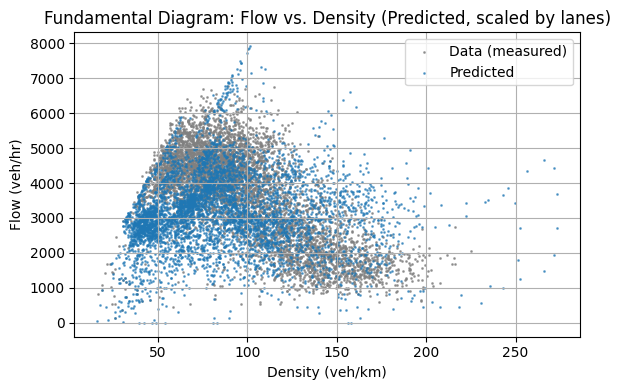

In [11]:
import matplotlib.pyplot as plt

# # Collect scaled predictions across all segments
all_rho_pred = rho_pred_array

print(all_rho_pred.shape)
all_v_pred = v_pred_array
all_q_pred = all_rho_pred*all_v_pred
# for seg in range(num_segments-2):
#     lane_num = best_results["lane_num"][seg]  # optimal lane count
#     rho_pred_seg = best_results["rho_pred"][seg] * lane_num
#     v_pred_seg = best_results["v_pred"][seg]
#     q_pred_seg = rho_pred_seg * v_pred_seg

#     all_rho_pred.append(rho_pred_seg)
#     all_q_pred.append(q_pred_seg)
#     all_v_pred.append(v_pred_seg)

# Stack predictions
all_rho_pred = np.hstack(all_rho_pred)
all_q_pred = np.hstack(all_q_pred)
all_v_pred = np.hstack(all_v_pred)
# Plot
plt.figure(figsize=(6, 4))
plt.scatter(rho_hat, q_hat, color='gray', alpha=0.7, s=1, label='Data (measured)')
plt.scatter(all_rho_pred, all_q_pred, alpha=0.6, s=1, label='Predicted')
plt.xlabel("Density (veh/km)")
plt.ylabel("Flow (veh/hr)")
plt.title("Fundamental Diagram: Flow vs. Density (Predicted, scaled by lanes)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


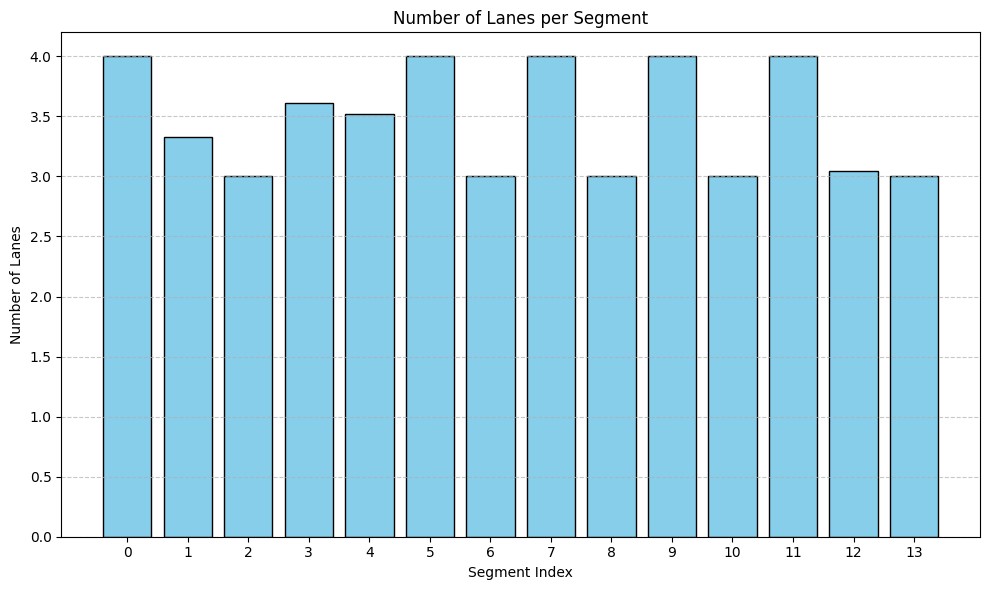

In [12]:
plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(num_lanes_array)), num_lanes_array, color="skyblue", edgecolor="black")

plt.xlabel("Segment Index")
plt.ylabel("Number of Lanes")
plt.title("Number of Lanes per Segment")
plt.xticks(np.arange(len(num_lanes_array)))  # show all indices
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()

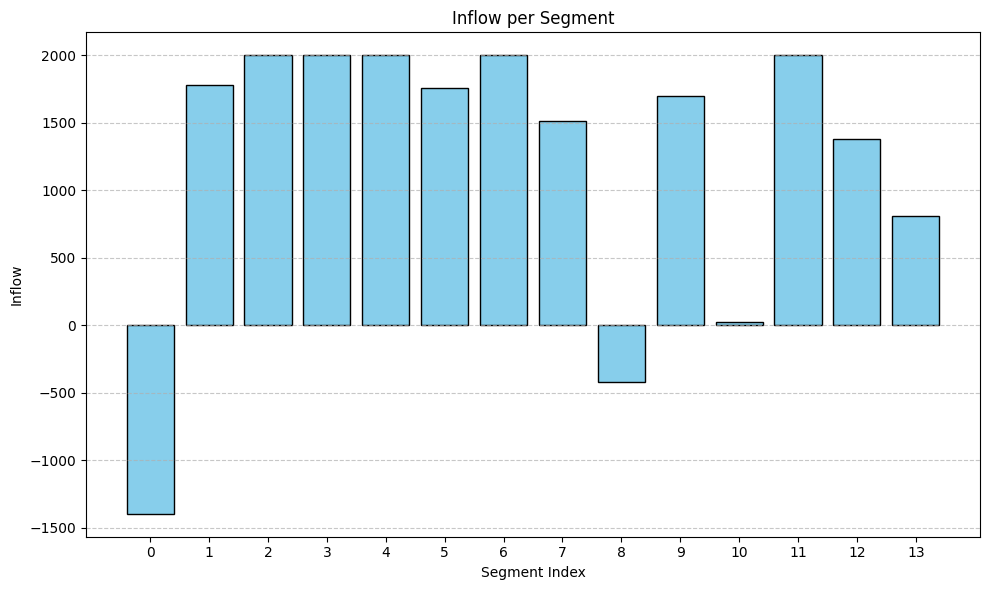

In [20]:
plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(r_inflow_array)), r_inflow_array, color="skyblue", edgecolor="black")

plt.xlabel("Segment Index")
plt.ylabel("Inflow")
plt.title("Inflow per Segment")
plt.xticks(np.arange(len(num_lanes_array)))  # show all indices
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()

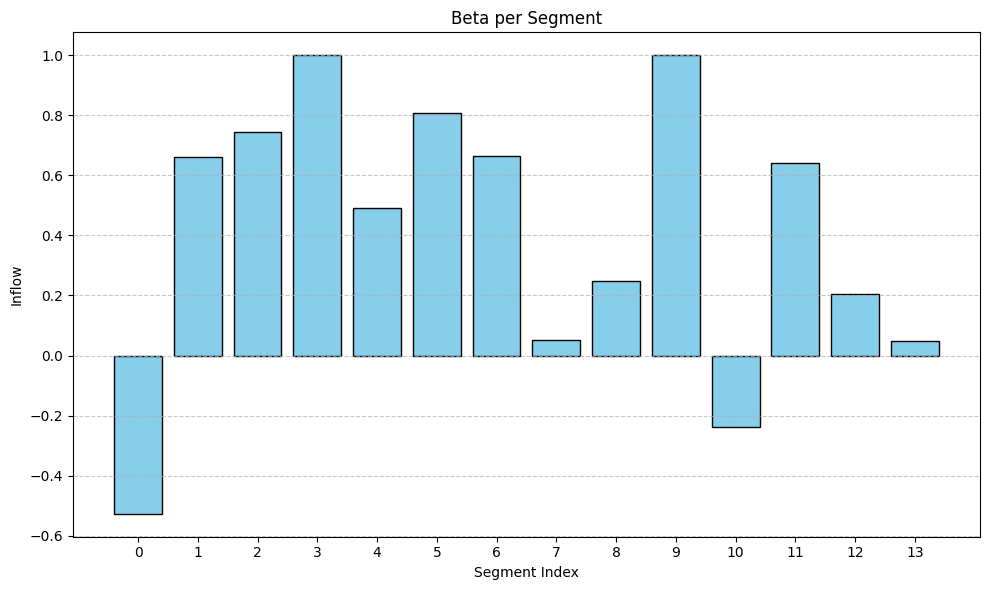

In [22]:
plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(beta_array)), beta_array, color="skyblue", edgecolor="black")

plt.xlabel("Segment Index")
plt.ylabel("Inflow")
plt.title("Beta per Segment")
plt.xticks(np.arange(len(num_lanes_array)))  # show all indices
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()

In [13]:
import numpy as np

def mape(flow_hat, flow_pred):
    """
    Compute the Mean Absolute Percentage Error (MAPE) between ground truth and prediction.

    Parameters:
        flow_hat (np.ndarray): Ground truth array of shape [t, i]
        flow_pred (np.ndarray): Predicted array of shape [t, i]

    Returns:
        float: The mean absolute percentage error (in percent)
    """
    # Avoid division by zero by masking out zero ground truth values
    mask = flow_hat != 0
    # print(flow_hat.shape)
    # print(flow_pred.shape)
    error = np.abs((flow_pred[mask] - flow_hat[mask]) / flow_hat[mask])
    return np.mean(error) * 100
def rmse(flow_hat, flow_pred):
    """
    Compute the Root Mean Squared Error (RMSE) between ground truth and prediction.

    Parameters:
        flow_hat (np.ndarray): Ground truth array of shape [t, i]
        flow_pred (np.ndarray): Predicted array of shape [t, i]

    Returns:
        float: The root mean squared error
    """
    error = flow_pred - flow_hat
    mse = np.mean(np.square(error))
    return np.sqrt(mse)


In [14]:
print(all_v_pred.shape)
q_array = rho_pred_array*v_pred_array
print("rho mape", mape(rho_hat[:,1:-1], rho_pred_array))
print("q mape", mape(q_hat[:, 1:-1], q_array))
print("v mape", mape(v_hat[:, 1:-1], v_pred_array))
print("----------------")
print("rho rmse", rmse(rho_hat[:,1:-1], rho_pred_array))
print("q rmse", rmse(q_hat[:, 1:-1], q_array))
print("v rmse", rmse(v_hat[:, 1:-1], v_pred_array))

(5040,)
rho mape 25.712284292664688
q mape 35.42370630823352
v mape 36.67191085870819
----------------
rho rmse 33.045222568220034
q rmse 1337.2411836095382
v rmse 11.830099959371283


Pred shape: (360, 14)
True shape: (360, 14)
Max true density: 225.06999625000026


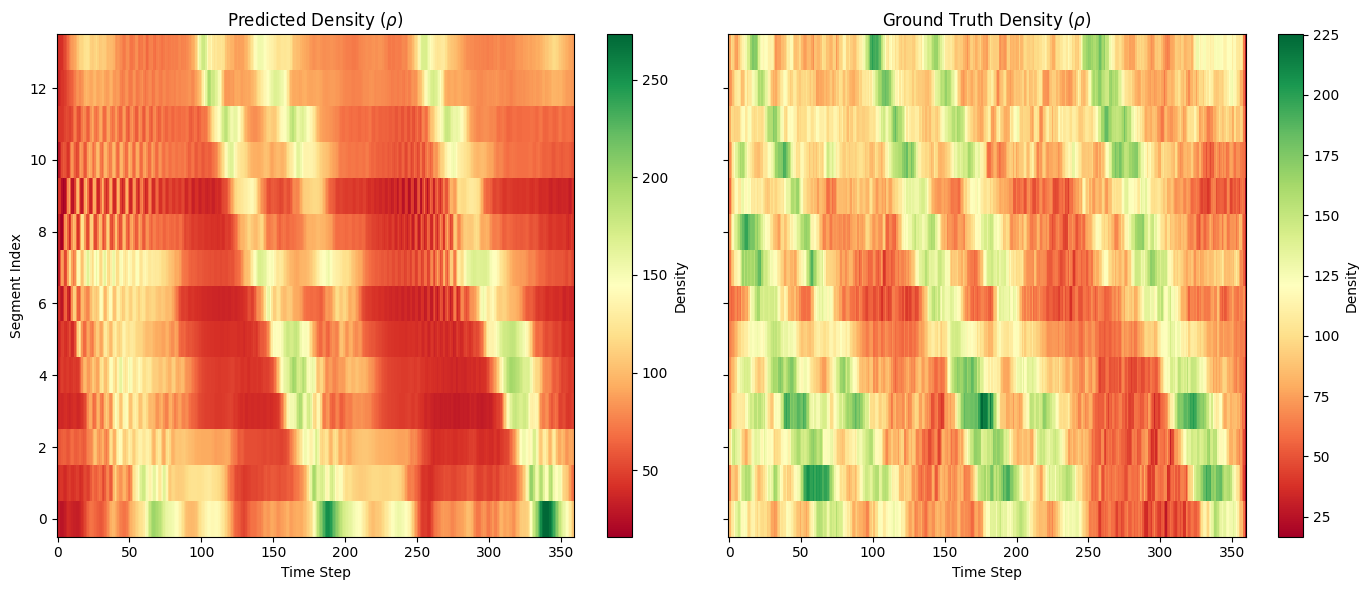

In [15]:
rho_plot_pred = rho_pred_array
rho_plot_true = rho_hat[:, 1:-1]

print("Pred shape:", rho_plot_pred.shape)
print("True shape:", rho_plot_true.shape)
print("Max true density:", np.max(rho_plot_true))

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# --- Prediction ---
im0 = axes[0].imshow(rho_plot_pred.T, aspect='auto', origin='lower',
                     cmap='RdYlGn', interpolation="none")
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('Segment Index')
axes[0].set_title('Predicted Density ($\\rho$)')
fig.colorbar(im0, ax=axes[0], label='Density')

# --- Ground Truth ---
im1 = axes[1].imshow(rho_plot_true.T, aspect='auto', origin='lower',
                     cmap='RdYlGn', interpolation="none")
axes[1].set_xlabel('Time Step')
axes[1].set_title('Ground Truth Density ($\\rho$)')
fig.colorbar(im1, ax=axes[1], label='Density')

plt.tight_layout()
plt.show()


[15.60562109 22.63969379 14.53123911 33.0528382  44.74894381 40.31822336
 36.43426698 50.4408325  24.55019846 12.00645115  5.34702448 21.88636564
 40.55200066 44.41112619]
[23.32140856 28.27033104 28.85348008 45.68523759 46.82848239 42.25378856
 71.1105354   1.13120292 35.39331337 34.03410038  7.24746509 27.90287554
 44.8474298  58.45325264]
Pred shape: (360, 14)
True shape: (360, 14)
Max true density: 102.5494591064967


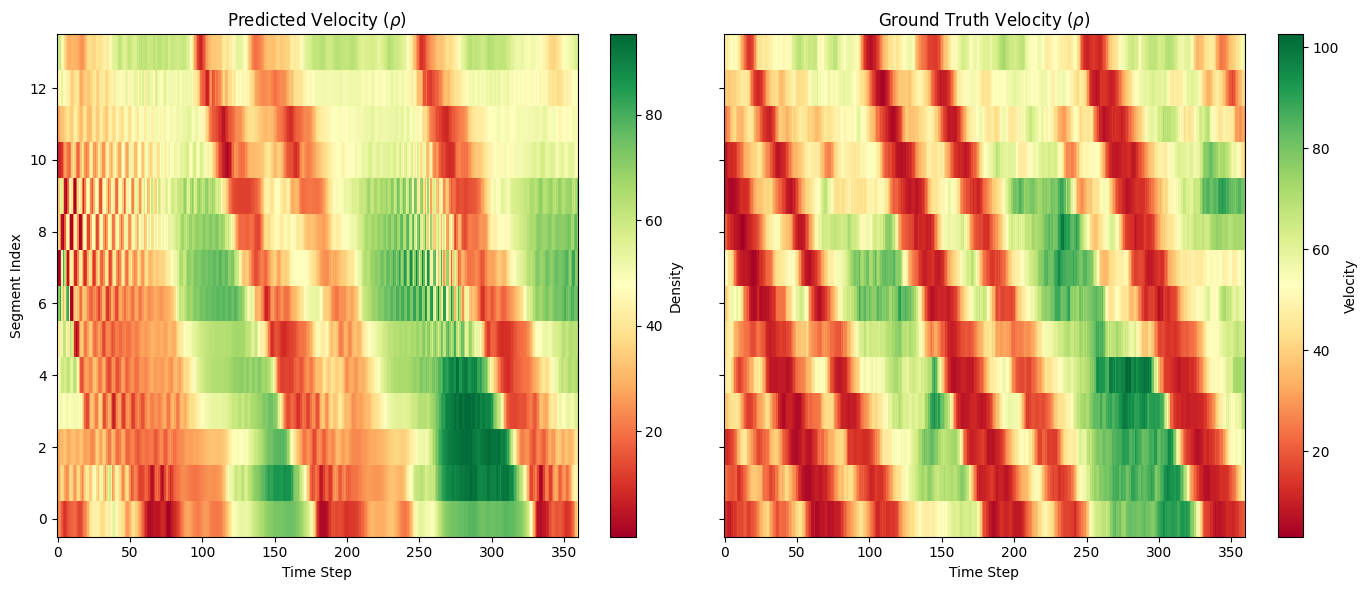

In [16]:
print(v_pred_array[0,:])
print(v_pred_array[1,:])
rho_plot_pred = v_pred_array
rho_plot_true = v_hat[:, 1:-1]

print("Pred shape:", rho_plot_pred.shape)
print("True shape:", rho_plot_true.shape)
print("Max true density:", np.max(rho_plot_true))

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# --- Prediction ---
im0 = axes[0].imshow(rho_plot_pred.T, aspect='auto', origin='lower',
                     cmap='RdYlGn', interpolation="none")
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('Segment Index')
axes[0].set_title('Predicted Velocity ($\\rho$)')
fig.colorbar(im0, ax=axes[0], label='Density')

# --- Ground Truth ---
im1 = axes[1].imshow(rho_plot_true.T, aspect='auto', origin='lower',
                     cmap='RdYlGn', interpolation="none")
axes[1].set_xlabel('Time Step')
axes[1].set_title('Ground Truth Velocity ($\\rho$)')
fig.colorbar(im1, ax=axes[1], label='Velocity')

plt.tight_layout()
plt.show()


Pred shape: (360, 14)
True shape: (360, 14)
Max true density: 6749.992799999934


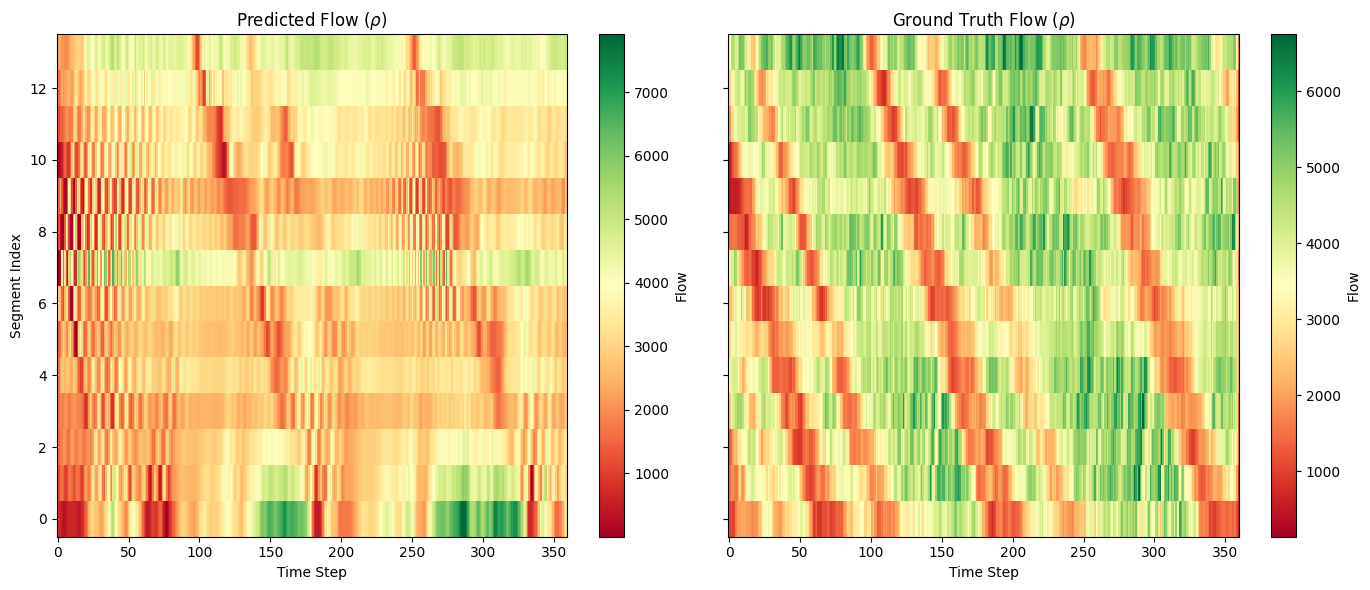

In [17]:
rho_plot_pred = rho_pred_array*v_pred_array
rho_plot_true = q_hat[:, 1:-1]

print("Pred shape:", rho_plot_pred.shape)
print("True shape:", rho_plot_true.shape)
print("Max true density:", np.max(rho_plot_true))

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# --- Prediction ---
im0 = axes[0].imshow(rho_plot_pred.T, aspect='auto', origin='lower',
                     cmap='RdYlGn', interpolation="none")
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('Segment Index')
axes[0].set_title('Predicted Flow ($\\rho$)')
fig.colorbar(im0, ax=axes[0], label='Flow')

# --- Ground Truth ---
im1 = axes[1].imshow(rho_plot_true.T, aspect='auto', origin='lower',
                     cmap='RdYlGn', interpolation="none")
axes[1].set_xlabel('Time Step')
axes[1].set_title('Ground Truth Flow ($\\rho$)')
fig.colorbar(im1, ax=axes[1], label='Flow')

plt.tight_layout()
plt.show()


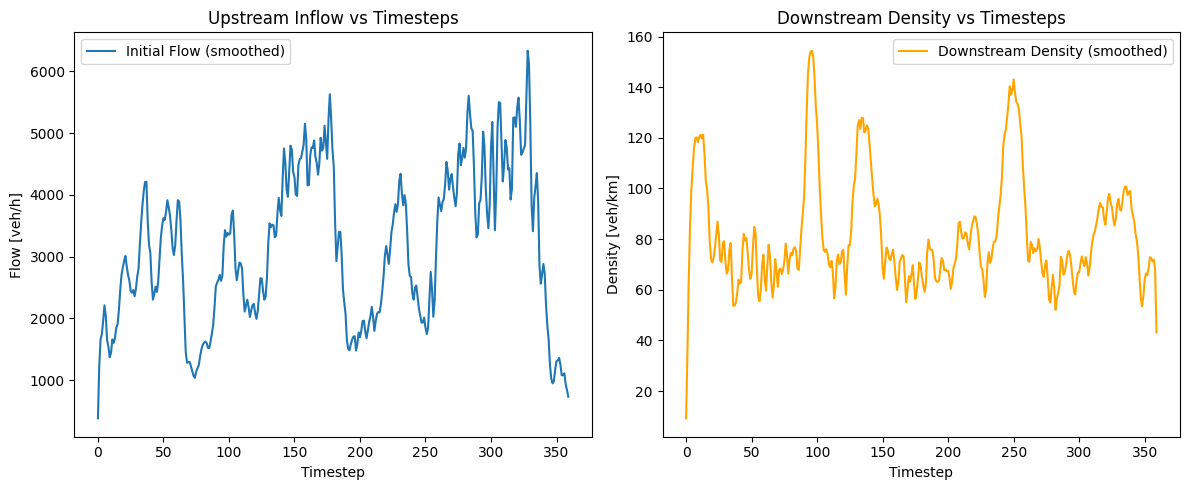

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def smooth_inflow(inflow, window_size=2):
    kernel = np.ones(window_size) / window_size
    smoothed = np.apply_along_axis(
        lambda m: np.convolve(m, kernel, mode='same'), axis=0, arr=inflow
    )
    return smoothed

# Example input arrays (replace with your real q_hat and rho_hat)
# timesteps = 100
# q_hat = np.random.uniform(500, 1000, size=(timesteps, 5))   # flow [veh/h]
# rho_hat = np.random.uniform(10, 50, size=(timesteps, 5))    # density [veh/km]

# Apply smoothing
initial_flow = smooth_inflow(q_hat[:, 0:1])       # upstream inflow
downstream_density = smooth_inflow(rho_hat[:, -1:])  # downstream density

# Plotting
plt.figure(figsize=(12, 5))

# Flow vs timesteps
plt.subplot(1, 2, 1)
plt.plot(initial_flow, label="Initial Flow (smoothed)")
plt.xlabel("Timestep")
plt.ylabel("Flow [veh/h]")
plt.title("Upstream Inflow vs Timesteps")
plt.legend()

# Density vs timesteps
plt.subplot(1, 2, 2)
plt.plot(downstream_density, color="orange", label="Downstream Density (smoothed)")
plt.xlabel("Timestep")
plt.ylabel("Density [veh/km]")
plt.title("Downstream Density vs Timesteps")
plt.legend()

plt.tight_layout()
plt.show()


In [19]:
def calculate_V(rho, VSL, a, rho_crit, v_free):
    return v_free * exp(-1 / a * (rho / rho_crit)**a)
def velocity_dynamics(current, prev_state, density, next_density, VSL, T, l, tau, eta, K, a, rho_crit, v_free):
    # tau = m.tau[seg]
    # eta = m.eta_high[seg]
    # K = m.K[seg]
    v_eq = calculate_V(density, VSL, a, rho_crit, v_free)
    term1 = T / tau * (v_eq - current)
    term2 = T / l * current * (prev_state - current)
    term3 = (eta * T) / (tau * l) * (next_density - density) / (density + K)
    return current + term1 + term2 - term3

v_free = v_free_array[7]
rho_crit = rho_crit_array[7]
a = a_array[7]
tau = tau_array[7]
eta = eta_high_array[7]
K = K_array[7]

current = v_pred_array[0,7]
prev_state = v_pred_array[0,6]
density = rho_pred_array[0,7]/num_lanes_array[7]
next_density = rho_pred_array[0,8]/num_lanes_array[8]
T = 10/3600
l = 0.4

print( velocity_dynamics(current, prev_state, density, next_density, 150, T, l, tau, eta, K, a, rho_crit, v_free))
print(v_pred_array[1, 7])

1.1312029163853055
1.1312029163853063
